In [1]:
# Load libriaries and functions.
import scipy
import pandas as pd
import numpy as np
import collections
import tensorflow as tf
tfk = tf.keras
tf.keras.backend.set_floatx("float64")
import tensorflow_probability as tfp
tfd = tfp.distributions
# Define helper functions.
neg_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

# Training on all data

In [14]:
NS = pd.read_excel("NS_EOS.xlsx")
X = NS.iloc[:, 0:7].values
y = NS.iloc[:, [7,9,11]].values
X_before_transformation = X

In [15]:
columns = NS.columns[0:8].tolist() + [NS.columns[9]]+ [NS.columns[11]]
inputs = columns[0:7]
outputs = columns[7:]

## Preprocessing


In [16]:
#Standardizing the data
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X = sc_X.fit_transform(X)
sc_y = StandardScaler()
y = sc_y.fit_transform(y)
X_t = np.hstack((X,y))
# Restore frame.
dataset = pd.DataFrame(X_t, columns=columns)

In [17]:
dataset

,e(0),rho(0),K(0),Q(0),J(0),L(0),Ksym(0),NS mass,R14,Lambda14
0,0.687358,0.302562,-0.381250,-0.766316,1.153811,-0.881592,-0.692423,0.191919,-0.753640,-0.771322
1,-0.968701,0.354830,0.261559,-2.441151,1.591098,-0.742932,-0.203642,0.953546,-0.538471,-0.300545
2,1.267572,1.478603,0.111733,-1.412748,0.781408,-1.244891,-0.081475,0.698675,-1.057272,-0.635172
3,-0.451408,0.929784,1.958939,-1.652364,0.152835,-0.455368,-0.329694,1.301007,-0.153793,0.044865
4,-2.569575,-1.030285,1.987198,-0.558311,-0.049194,-1.039313,-0.412418,1.709199,-0.235230,0.243536
...,...,...,...,...,...,...,...,...,...,...
6646,0.011216,0.302562,-0.026111,0.063204,0.977421,-1.552898,-1.405772,-0.717055,-1.566186,-1.434525
6647,0.011732,-0.089452,-0.026050,0.063209,1.528291,-1.160043,-1.025951,0.125215,-0.980908,-0.934861
6648,0.009669,-0.141721,-0.025982,0.063176,1.485894,-1.555810,-1.496734,-0.580659,-1.494246,-1.390639
6649,0.012247,0.015085,-0.026016,0.063193,1.973312,-1.265334,-1.205646,-0.007199,-1.134415,-1.081491


In [48]:
# Define some hyperparameters.
n_epochs = 40
n_samples = dataset.shape[0]
n_batches = 32
batch_size = np.floor(n_samples/n_batches)
buffer_size = n_samples

# Define training and test data sizes.
n_train = int(dataset.shape[0]) #Complete dataset

# Define dataset instance.
data = tf.data.Dataset.from_tensor_slices((dataset[inputs].values, dataset[outputs].values))
data = data.shuffle(n_samples, reshuffle_each_iteration=True)

# Define train and test data instances.
data_train = data.take(n_train).batch(batch_size).repeat(n_epochs)
data_test = data.skip(n_train).batch(1).repeat(n_epochs)  #this is 0

## Model Building
### Aleotoric Uncertainty
To account for aleotoric uncertainty, which arises from the noise in the output, dense layers are combined with probabilistic layers. More specifically, the mean and covariance matrix of the output is modelled as a function of the input and parameter weights. The first hidden layer shall consist of 10 nodes, the second one needs 3 nodes for the means plus ten nodes for the variances and covariances of the 3-dimensional (there are 3 outputs) multivariate Gaussian posterior probability distribution in the final layer. This is achieved using the params_size method of the last layer (MultivariateNormalTriL), which is the declaration of the posterior probability distribution structure, in this case a multivariate normal distribution in which only one half of the covariance matrix is estimated (due to symmetry). The total number of parameters in the model is 179 — estimated by variational methods. The deterministic version of this neural network consists of an input layer, ten latent variables (hidden nodes), and an output layer (114 parameters), which does not include the uncertainty in the parameters weights.

In [49]:
class EarlyStoppingAtMinLoss(tfk.callbacks.Callback):
    """Stop training before loss becomes negative

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, patience=0):
        super(EarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("loss")
        if np.less(current, self.best) and current>0:
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        elif np.less(current,0):
            '''self.wait += 1
            if self.wait >= self.patience:'''
            self.stopped_epoch = epoch
            self.model.stop_training = True
            print("\n Restoring model weights from the end of the best epoch.")
            self.model.set_weights(self.best_weights)
        

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %02d: early stopping" % (self.stopped_epoch))


In [50]:
# Define prior for regularization.
len_inputs = 7
len_outputs = 3
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(len_outputs, dtype=tf.float64), scale=1.0), reinterpreted_batch_ndims=1)
# Define model instance.
def BNN_Model(no_of_nodes,i):
  model = tfk.Sequential([tfk.layers.InputLayer(input_shape=(len_inputs,), name="input"),
                          tfk.layers.Dense(no_of_nodes, activation="relu", name="dense_1"),
                          tfk.layers.Dense(tfp.layers.MultivariateNormalTriL.params_size(len_outputs), activation=None, 
                                          name="distribution_weights"),
                        
                          tfp.layers.MultivariateNormalTriL(len_outputs, 
                                                            activity_regularizer=
                                                            tfp.layers.KLDivergenceRegularizer(prior,weight=1/n_batches)
                                    , name="output")]
                        , name="BNN-"+str(i))
  # Compile model.
  model.compile(optimizer="adam", loss=neg_log_likelihood)
  # Run training session.
  model.fit(data_train, epochs=n_epochs, validation_data=data_test, verbose=True,callbacks=[EarlyStoppingAtMinLoss()])
  # Describe model.
  return model

In [51]:
final_models_list = [20,10,9]
models = []
for i in final_models_list:
  model_i = BNN_Model(i,i)
  print("model "+str(i)+" trained.")
  models.append(model_i)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Epoch 1/40
1320/1320 [==============================] - 3s 2ms/step - loss: 3.7154
Epoch 2/40
1320/1320 [==============================] - 3s 3ms/step - loss: 0.8057
Epoch 3/40
1319/1320 [============================>.] - ETA: 0s - loss: -1.2681
 Restoring model weights from the end of the best epoch.
1320/1320 [==============================] - 3s 3ms/step - loss: -1.2683
Epoch 02: early stopping
model 20 trained.
Epoch 1/40
1320/1320 [==============================] - 4s 3ms/step - loss: 102.5294
Epoch 2/40
1320/1320 [==============================] - 3s 3ms/step - loss: 9.6741
Epoch 3/40
1320/1320 [==============================] - 3s 3ms/step - loss: 5.4015
Epoch 4/40
1320/1320 [==============================] - 3s 3ms/step - loss: 4.0418
Epoch 5/40
1320/1320 [==============================] - 3s 2ms/step - loss: 3.7506
Epoch 6/40
1320/1320 [==============================] - 3s 3ms/step - loss: 3

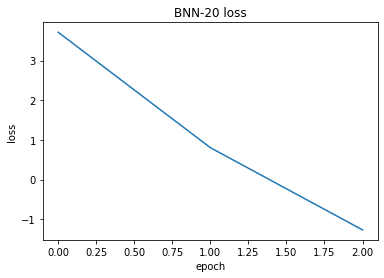

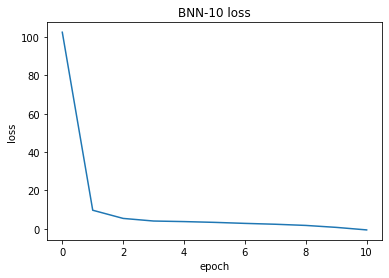

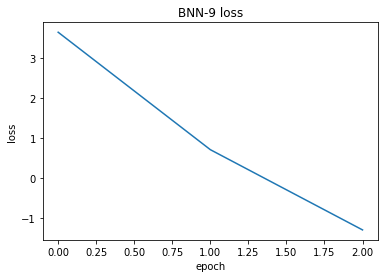

In [52]:
import matplotlib.pyplot as plt
# "Loss"
for model in models:
  plt.plot(model.history.history['loss'])
  plt.title(model.name+' loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.show()

The activity_regularizer argument acts as prior for the output layer (the weight has to be adjusted to the number of batches). The training session might take a while depending on the specifications of your machine.

# Prediction
Since it is a probabilistic model, a Monte Carlo experiment is performed to provide a prediction. In particular, every prediction of a sample x results in a different output y, which is why the expectation over many individual predictions has to be calculated. Additionally, the variance can be determined this way.

## Sampling

In [53]:
#Input mu (mean) -> [e(0),rho(0),K(0),Q(0),J(0),L(0),Ksym(0)]
mu = np.array([-16.0,0.16,230.0,300,32,60,-100])  #small errata in paper, the mean value of Q(0) = +300
#Input sigma (variance) -> [e(0),rho(0),K(0),Q(0),J(0),L(0),Ksym(0)]
sigma = np.array([0.25,0.005,20,100,3,20,100])
#correlations matrix
        #        [e,     rho,     K,     Q,    J,     L,     Ksym]
corr = np.array([[ 1.,   -0.56, -0.23,  0.06,  0.,    0.04,  0.04],
                [-0.56,  1.,   -0.24,  0.27, -0.01, -0.01,  0.07],
                [-0.23, -0.24,  1.,   -0.85, -0.15, -0.22, -0.47],
                [ 0.06,  0.27, -0.85,  1.,    0.04,  0.12,  0.4 ],
                [ 0.,   -0.01, -0.15,  0.04,  1.,    0.82,  0.4 ],
                [ 0.04, -0.01, -0.22,  0.12,  0.82,  1.,    0.81],
                [ 0.04,  0.07, -0.47,  0.4,   0.4,   0.81,  1.  ]])
# Sigma (covariance matrix)
d = np.diag(sigma)
Sigma = d*corr*d
X_sample = []
i=0
flag=0
number_of_samples = 100
while flag==0:
    X_test = np.random.multivariate_normal(mu,Sigma,size=(number_of_samples*2,1,1))
    X_test = X_test[:,0,0]
    lower_bound = mu-2*sigma
    upper_bound = mu+2*sigma
    for x in X_test:
        check = (x>lower_bound)==(x<upper_bound)
        if check.all()==True:
            X_sample.append(x.tolist())
    i+=1
    if np.array(X_sample).shape[0]>=number_of_samples:
        flag=1
X_sample = np.array(X_sample)[:100]
print("Number of iterations= "+str(i))
X_sample.shape

Number of iterations= 1


(100, 7)

In [85]:
test_untransformed = pd.DataFrame(data=X_sample,columns=inputs)
test_untransformed

,e(0),rho(0),K(0),Q(0),J(0),L(0),Ksym(0)
0,-15.736308,0.156859,244.101472,363.729541,29.631643,99.822570,-172.853646
1,-16.432239,0.158231,237.724758,292.016826,32.649365,45.694169,-207.196570
2,-15.671115,0.156580,233.918523,257.755429,34.686872,41.294243,-85.927067
3,-15.952438,0.162968,217.714749,293.181784,37.008157,38.530173,-189.091037
4,-15.914012,0.150298,202.617507,295.111658,26.809657,67.798354,-179.104606
...,...,...,...,...,...,...,...
95,-16.307431,0.155515,240.395479,467.637131,37.294641,87.213317,-102.204064
96,-15.783386,0.167173,215.217607,276.300176,29.982700,61.187725,-116.886455
97,-16.340952,0.165997,228.257148,422.910866,32.062723,76.526831,-163.005982
98,-15.814349,0.159863,229.668049,380.407060,30.557722,66.284303,-160.158070


In [55]:
test = sc_X.transform(X_sample)
test_df = pd.DataFrame(data=test,columns=inputs)
test_df

,e(0),rho(0),K(0),Q(0),J(0),L(0),Ksym(0)
0,1.371197,-0.805669,0.930720,0.922559,-0.899510,2.154432,-1.592892
1,-2.218036,-0.447329,0.498061,-0.044440,0.181075,-1.185491,-2.086095
2,1.707424,-0.878642,0.239808,-0.506432,0.910665,-1.456983,-0.344528
3,0.256516,0.790730,-0.859616,-0.028731,1.741870,-1.627536,-1.826079
4,0.454695,-2.520472,-1.883962,-0.002708,-1.910006,0.178419,-1.682663
...,...,...,...,...,...,...,...
95,-1.574345,-1.157137,0.679269,2.323684,1.844454,1.376394,-0.578284
96,1.128393,1.889808,-1.029047,-0.256368,-0.773804,-0.229481,-0.789140
97,-1.747231,1.582298,-0.144315,1.720580,-0.028990,0.716999,-1.451468
98,0.968705,-0.020657,-0.048586,1.147444,-0.567900,0.084996,-1.410569


## Predicting


In [76]:
#Selecting model to show output (best overall is 20)
samples = test.shape[0]
iterations = 50
len_inputs = 7
len_outputs = 3
model_i = models[0]
X_true = np.empty(shape=(samples, len_inputs))
Y_pred = np.empty(shape=(samples, len_outputs, iterations))
for i in range(samples):
    # Define datatest instance.
    X_true[i,:] = X_sample[i,:]
    arr = test[i,:]
    for k in range(iterations):
      Y_pred[i,:,k] = model_i.predict([[arr[0],arr[1],arr[2],arr[3],arr[4],arr[5],arr[6]]])
      Y_pred[i,:,k] = sc_y.inverse_transform(Y_pred[i,:,k])

# Calculate mean and standard deviation.
Y_pred_m = np.mean(Y_pred, axis=-1)
Y_pred_s = np.std(Y_pred, axis=-1)

In [86]:
final_result = test_untransformed
final_result['NS Mass Mean'] = Y_pred_m[:,0].transpose()
final_result['NS Mass Std_dev'] = Y_pred_s[:,0].transpose()
final_result['NS Radius Mean'] = Y_pred_m[:,1].transpose()
final_result['NS Radius Std_dev'] = Y_pred_s[:,1].transpose()
final_result['Lambda 1.6 Mean'] = Y_pred_m[:,2].transpose()
final_result['Lambda 1.6 Std_dev'] = Y_pred_s[:,2].transpose()

In [87]:
final_result

,e(0),rho(0),K(0),Q(0),J(0),L(0),Ksym(0),NS Mass Mean,NS Mass Std_dev,NS Radius Mean,NS Radius Std_dev,Lambda 1.6 Mean,Lambda 1.6 Std_dev
0,-15.736308,0.156859,244.101472,363.729541,29.631643,99.822570,-172.853646,1.917556,0.088663,13.691549,0.361807,460.297958,24.150715
1,-16.432239,0.158231,237.724758,292.016826,32.649365,45.694169,-207.196570,1.914409,0.089453,11.900110,0.207289,229.542856,26.844975
2,-15.671115,0.156580,233.918523,257.755429,34.686872,41.294243,-85.927067,2.201606,0.033876,11.959676,0.447267,378.297303,44.889432
3,-15.952438,0.162968,217.714749,293.181784,37.008157,38.530173,-189.091037,1.897157,0.053039,11.161738,0.238888,163.794377,19.382907
4,-15.914012,0.150298,202.617507,295.111658,26.809657,67.798354,-179.104606,1.851736,0.111333,12.532059,0.253718,285.780036,36.228474
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-16.307431,0.155515,240.395479,467.637131,37.294641,87.213317,-102.204064,2.017232,0.029862,13.511227,0.322894,472.794375,41.905097
96,-15.783386,0.167173,215.217607,276.300176,29.982700,61.187725,-116.886455,1.948965,0.043568,12.105487,0.180143,273.750722,19.168541
97,-16.340952,0.165997,228.257148,422.910866,32.062723,76.526831,-163.005982,1.817529,0.093714,12.182929,0.233250,205.192960,11.417247
98,-15.814349,0.159863,229.668049,380.407060,30.557722,66.284303,-160.158070,1.914111,0.076354,12.383295,0.251079,277.117956,24.340234


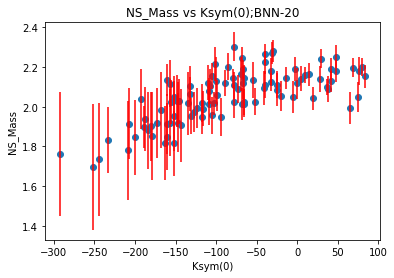

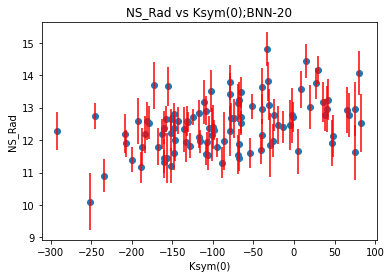

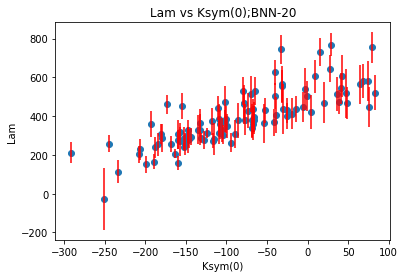

In [77]:
#plot of values and error bars
import sklearn.metrics
import matplotlib.pyplot as plt
titles = ['NS_Mass','NS_Rad','Lam']
for i in range(3):
    fig, ax = plt.subplots()
    ax.scatter(X_true[:,6],Y_pred_m[:,i])
    ax.errorbar(X_true[:,6],Y_pred_m[:,i],yerr=2*Y_pred_s[:,i],ecolor='red',linestyle="None")
    ax.set_ylabel(titles[i])
    ax.set_xlabel('Ksym(0)')
    plt.title(titles[i]+' vs Ksym(0);'+model_i.name)
    plt.show()